# AIE7 Certification Challenge - End-to-end Agentic RAG Prototype

## Part 1: Environment Variables

In [10]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [11]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7-cert {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

In [12]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [48]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import TextLoader


path = "./rag_dataset/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
txt_loader = DirectoryLoader(path, glob="**/*.txt", loader_cls=TextLoader,
)

docs = loader.load()
txt = txt_loader.load()
all_docs = docs + txt

print(f"Loaded {len(docs)} PDFs + {len(txt)} TXTs  →  {len(all_docs)} documents")

Loaded 85 PDFs + 1 TXTs  →  86 documents


## Part 2: Tool belt

In [ ]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200,
    length_function = tiktoken_len,
)

finance_resources_chunks = text_splitter.split_documents(all_docs)

In [50]:
len(finance_resources_chunks)

132

In [51]:
from operator import itemgetter

In [53]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [54]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    documents=finance_resources_chunks,
    embedding=embedding_model,
    location=":memory:"
)

In [55]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

In [56]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [57]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

In [58]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

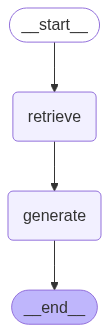

In [59]:
rag_graph

In [60]:
rag_graph.invoke({"question" : "When do I recognize revenue?"})

{'question': 'When do I recognize revenue?',
 'context': [Document(metadata={'producer': 'macOS Version 14.4.1 (Build 23E224) Quartz PDFContext', 'creator': 'Pages', 'creationdate': "D:20250805010313Z00'00'", 'source': 'rag_dataset/FASB.pdf', 'file_path': 'rag_dataset/FASB.pdf', 'total_pages': 78, 'format': 'PDF 1.3', 'title': 'FASB', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250805010313Z00'00'", 'trapped': '', 'modDate': "D:20250805010313Z00'00'", 'creationDate': "D:20250805010313Z00'00'", 'page': 30, '_id': 'a6b46ce53475444da94dda08691b52cb', '_collection_name': 'e7a04e6639da46cd8af1eb0ad013b8af'}, page_content='cost as a separate category in accordance with paragraph 220-40-50-22(p). \n220-40-55-24 Entity X provides the following disclosure. \n20X4 20X3 20X2 \nDepreciation $ 164,232 $ 146,403 $ 145,907 \nOperating lease expense 152,445 103,239 149,842 \nOther occupancy expenses (a) 59,910 30,233 53,930 \n$ 376,587 $ 279,875 $ 349,679 \n(a) \nIntangible asset amor

In [61]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

In [62]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [63]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nYou are an accounting and finance expert, use the tools available to you to answer the questions. Say I don't know if the question is not within the domain of accounting and finance."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [64]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [65]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [66]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=rag_graph
)

In [67]:
contextual_compression_retrieval_chain = (
    {
        "context": itemgetter("question") | compression_retriever,
        "question": itemgetter("question"),
    }
    | {"response": chat_prompt | openai_chat_model,
       "context": itemgetter("context")}
)


In [82]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about finance policies and variances"""
  return rag_graph.invoke({"question" : query})

In [84]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

In [85]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [86]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are an accounting and finance assistant who can search for up-to-date info using the tavily search engine.  Answer I don't know if the query is not about accounting and finance.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

In [87]:
research_agent = create_agent(
    llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on accounting and finance policies and methods. Say I don't know if you don't know the answer.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="FinanceRetriever")

In [88]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, FinanceRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "FinanceRetriever"],
)

In [89]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("FinanceRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

In [90]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("FinanceRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "FinanceRetriever": "FinanceRetriever", "FINISH": END},
)

In [91]:
research_graph.set_entry_point("supervisor")
compiled_research_graph = research_graph.compile()

In [92]:
import nest_asyncio
nest_asyncio.apply()

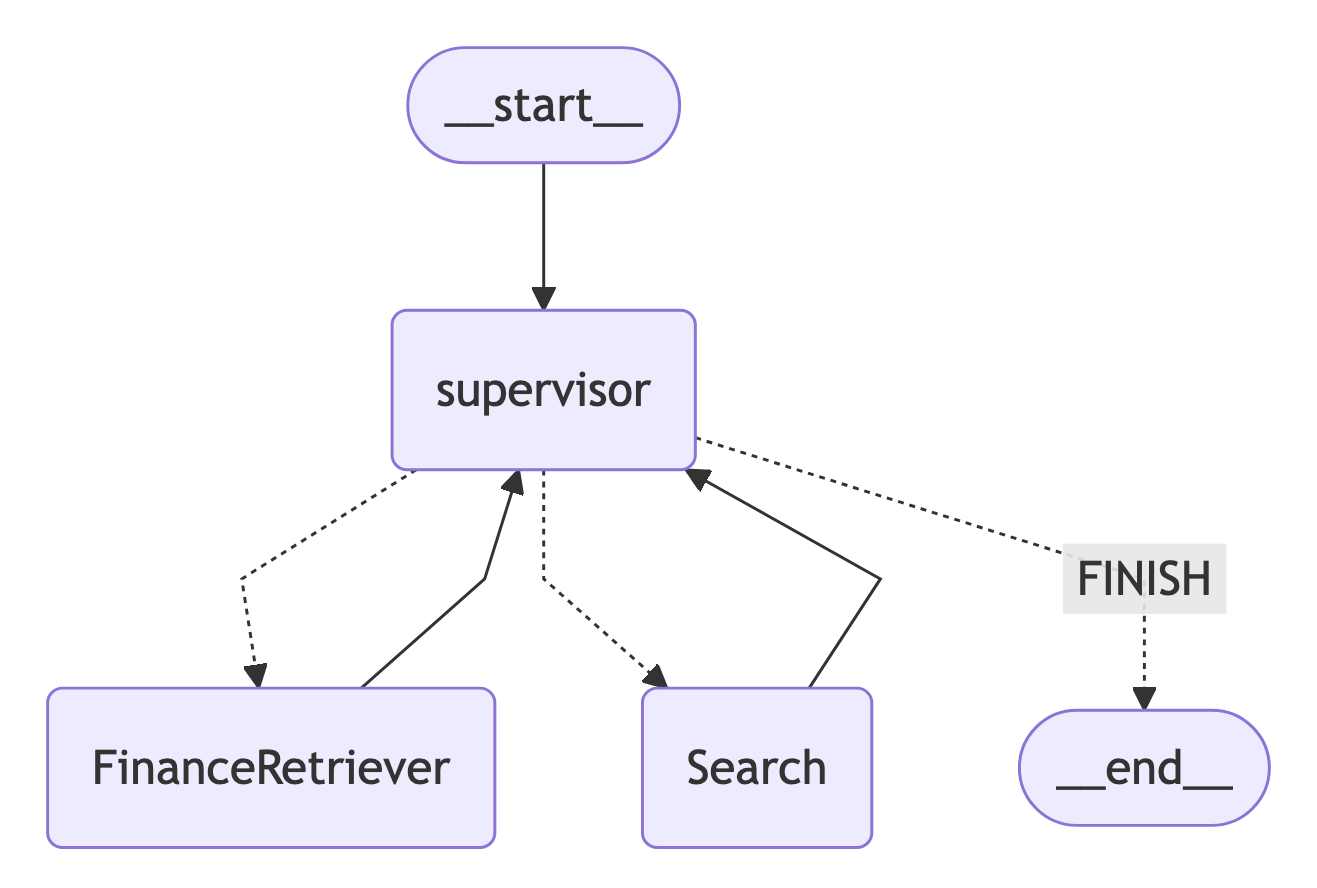

In [93]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [94]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_research_graph

In [95]:
for s in research_chain.stream(
    "How was the company performance in March", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'FinanceRetriever'}}
---
{'FinanceRetriever': {'messages': [HumanMessage(content="I don't know.", additional_kwargs={}, response_metadata={}, name='FinanceRetriever')]}}
---
{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content="I don't know.", additional_kwargs={}, response_metadata={}, name='Search')]}}
---
{'supervisor': {'next': 'FinanceRetriever'}}
---
{'FinanceRetriever': {'messages': [HumanMessage(content="I don't know.", additional_kwargs={}, response_metadata={}, name='FinanceRetriever')]}}
---
{'supervisor': {'next': 'FinanceRetriever'}}
---
{'FinanceRetriever': {'messages': [HumanMessage(content="I don't know.", additional_kwargs={}, response_metadata={}, name='FinanceRetriever')]}}
---
{'supervisor': {'next': 'FinanceRetriever'}}
---
{'FinanceRetriever': {'messages': [HumanMessage(content="I don't know.", additional_kwargs={}, response_metadata={}, name='FinanceRetriever')]}}
---
{'supervisor': {'next': 'FinanceRetrieve